Movie Studio Analysis

Overview

Business Problem

Your company now sees all the big companies creating original video content and they want to get in on the fun. They have decided to create a new movie studio, but they don’t know anything about creating movies. You are charged with exploring what types of films are currently doing the best at the box office. You must then translate those findings into actionable insights that the head of your company's new movie studio can use to help decide what type of films to create.

In the last 10 years, which genre was the most profitable at the box office. profits between genres. 

Most popular english movies filtered by user rating???
filters - year, english, gross profit, user rating, best director
3 recommendations?
comedy vs drama


** to make 2x to 3x more profit 
set budget = movies under between 5-80 million, medium budget movies
genre of movies - filter

Data Understanding

In [1]:
import pandas as pd
import numpy as np 
from scipy import stats
import seaborn as sns
import statsmodels.api as sm

import sqlite3
import zipfile 

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read in movie budgets dataset
movie_budgets = pd.read_csv('data/tn.movie_budgets.csv.gz')
movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [3]:
movie_budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [4]:
#create new column release year from release date
movie_budgets['release_year'] = movie_budgets['release_date'].str[-4:].astype(int)
movie_budgets


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279",2009
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875",2011
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350",2019
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963",2015
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747",2017
...,...,...,...,...,...,...,...
5777,78,"Dec 31, 2018",Red 11,"$7,000",$0,$0,2018
5778,79,"Apr 2, 1999",Following,"$6,000","$48,482","$240,495",1999
5779,80,"Jul 13, 2005",Return to the Land of Wonders,"$5,000","$1,338","$1,338",2005
5780,81,"Sep 29, 2015",A Plague So Pleasant,"$1,400",$0,$0,2015


In [5]:
#create new column release_month from release date
movie_budgets['release_month'] = movie_budgets['release_date'].str.split().str[0]
movie_budgets

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,release_month
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279",2009,Dec
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875",2011,May
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350",2019,Jun
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963",2015,May
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747",2017,Dec
...,...,...,...,...,...,...,...,...
5777,78,"Dec 31, 2018",Red 11,"$7,000",$0,$0,2018,Dec
5778,79,"Apr 2, 1999",Following,"$6,000","$48,482","$240,495",1999,Apr
5779,80,"Jul 13, 2005",Return to the Land of Wonders,"$5,000","$1,338","$1,338",2005,Jul
5780,81,"Sep 29, 2015",A Plague So Pleasant,"$1,400",$0,$0,2015,Sep


In [6]:
#filter for release year equal and above 2000
movie_budgets_filtered = movie_budgets[movie_budgets['release_year'] >= 2000]
movie_budgets_filtered 


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,release_month
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279",2009,Dec
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875",2011,May
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350",2019,Jun
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963",2015,May
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747",2017,Dec
...,...,...,...,...,...,...,...,...
5776,77,"Dec 31, 2004",The Mongol King,"$7,000",$900,$900,2004,Dec
5777,78,"Dec 31, 2018",Red 11,"$7,000",$0,$0,2018,Dec
5779,80,"Jul 13, 2005",Return to the Land of Wonders,"$5,000","$1,338","$1,338",2005,Jul
5780,81,"Sep 29, 2015",A Plague So Pleasant,"$1,400",$0,$0,2015,Sep


In [7]:
# Remove the dollar sign and commas, then convert the values to integers for production_budget
movie_budgets_filtered['production_budget'] = movie_budgets_filtered['production_budget'].astype(str)
movie_budgets_filtered['production_budget'] = movie_budgets_filtered['production_budget'].str.replace('$', '').str.replace(',', '').astype(int)

movie_budgets_filtered


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,release_month
0,1,"Dec 18, 2009",Avatar,425000000,"$760,507,625","$2,776,345,279",2009,Dec
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,"$241,063,875","$1,045,663,875",2011,May
2,3,"Jun 7, 2019",Dark Phoenix,350000000,"$42,762,350","$149,762,350",2019,Jun
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,"$459,005,868","$1,403,013,963",2015,May
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,"$620,181,382","$1,316,721,747",2017,Dec
...,...,...,...,...,...,...,...,...
5776,77,"Dec 31, 2004",The Mongol King,7000,$900,$900,2004,Dec
5777,78,"Dec 31, 2018",Red 11,7000,$0,$0,2018,Dec
5779,80,"Jul 13, 2005",Return to the Land of Wonders,5000,"$1,338","$1,338",2005,Jul
5780,81,"Sep 29, 2015",A Plague So Pleasant,1400,$0,$0,2015,Sep


In [8]:
# Remove the dollar sign and commas, then convert the values to integers for worldwide_gross
movie_budgets_filtered['worldwide_gross'] = movie_budgets_filtered['worldwide_gross'].astype(str)
movie_budgets_filtered['worldwide_gross'] = movie_budgets_filtered['worldwide_gross'].str.replace('$', '').str.replace(',', '').astype(int)
movie_budgets_filtered['domestic_gross'] = movie_budgets_filtered['domestic_gross'].astype(str)
movie_budgets_filtered['domestic_gross'] = movie_budgets_filtered['domestic_gross'].str.replace('$', '').str.replace(',', '').astype(int)

movie_budgets_filtered


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,release_month
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,2009,Dec
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,2011,May
2,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,2019,Jun
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,2015,May
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,2017,Dec
...,...,...,...,...,...,...,...,...
5776,77,"Dec 31, 2004",The Mongol King,7000,900,900,2004,Dec
5777,78,"Dec 31, 2018",Red 11,7000,0,0,2018,Dec
5779,80,"Jul 13, 2005",Return to the Land of Wonders,5000,1338,1338,2005,Jul
5780,81,"Sep 29, 2015",A Plague So Pleasant,1400,0,0,2015,Sep


In [9]:
#create ROI column
movie_budgets_filtered['ROI'] = round((movie_budgets_filtered['worldwide_gross'] / movie_budgets_filtered['production_budget']))
movie_budgets_filtered

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,release_month,ROI
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,2009,Dec,7.0
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,2011,May,3.0
2,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,2019,Jun,0.0
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,2015,May,4.0
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,2017,Dec,4.0
...,...,...,...,...,...,...,...,...,...
5776,77,"Dec 31, 2004",The Mongol King,7000,900,900,2004,Dec,0.0
5777,78,"Dec 31, 2018",Red 11,7000,0,0,2018,Dec,0.0
5779,80,"Jul 13, 2005",Return to the Land of Wonders,5000,1338,1338,2005,Jul,0.0
5780,81,"Sep 29, 2015",A Plague So Pleasant,1400,0,0,2015,Sep,0.0


In [10]:
#filtering ROI above 200.0
movie_budgets_filtered = movie_budgets_filtered[movie_budgets_filtered["ROI"] >= 200.0]
movie_budgets_filtered

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,release_month,ROI
5492,93,"Sep 25, 2009",Paranormal Activity,450000,107918810,194183034,2009,Sep,432.0
5679,80,"Jul 10, 2015",The Gallows,100000,22764410,41656474,2015,Jul,417.0
5709,10,"May 7, 2004",Super Size Me,65000,11529368,22233808,2004,May,342.0


In [11]:
# Filter rows where the production_budget is less than or equal to 80 million
budgets = movie_budgets_filtered[movie_budgets_filtered['production_budget'] <= 80000000]
budgets.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3 entries, 5492 to 5709
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 3 non-null      int64  
 1   release_date       3 non-null      object 
 2   movie              3 non-null      object 
 3   production_budget  3 non-null      int64  
 4   domestic_gross     3 non-null      int64  
 5   worldwide_gross    3 non-null      int64  
 6   release_year       3 non-null      int64  
 7   release_month      3 non-null      object 
 8   ROI                3 non-null      float64
dtypes: float64(1), int64(5), object(3)
memory usage: 240.0+ bytes


In [12]:
# Connect and Read in SQL tables
conn = sqlite3.connect('im.db.zip')
zip_file_path = 'data/im.db.zip'

with zipfile.ZipFile('data/im.db.zip', 'r') as zip_ref:
    zip_ref.extractall('unzippedData')

database_path = 'unzippedData/im.db'
conn = sqlite3.connect(database_path)

In [13]:
schema_df = pd.read_sql("""

SELECT *
FROM sqlite_master

""", conn)

schema_df


,type,name,tbl_name,rootpage,sql
0,table,movie_basics,movie_basics,2,"CREATE TABLE ""movie_basics"" (\n""movie_id"" TEXT..."
1,table,directors,directors,3,"CREATE TABLE ""directors"" (\n""movie_id"" TEXT,\n..."
2,table,known_for,known_for,4,"CREATE TABLE ""known_for"" (\n""person_id"" TEXT,\..."
3,table,movie_akas,movie_akas,5,"CREATE TABLE ""movie_akas"" (\n""movie_id"" TEXT,\..."
4,table,movie_ratings,movie_ratings,6,"CREATE TABLE ""movie_ratings"" (\n""movie_id"" TEX..."
5,table,persons,persons,7,"CREATE TABLE ""persons"" (\n""person_id"" TEXT,\n ..."
6,table,principals,principals,8,"CREATE TABLE ""principals"" (\n""movie_id"" TEXT,\..."
7,table,writers,writers,9,"CREATE TABLE ""writers"" (\n""movie_id"" TEXT,\n ..."


In [14]:
# reading the movie_basics table
movie_basics = pd.read_sql(
    """
    SELECT *
    FROM movie_basics
    WHERE start_year <= 2020
    """, conn
)
movie_basics

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"
...,...,...,...,...,...,...
146013,tt9916538,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,2019,123.0,Drama
146014,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,NaN,Documentary
146015,tt9916706,Dankyavar Danka,Dankyavar Danka,2013,NaN,Comedy
146016,tt9916730,6 Gunn,6 Gunn,2017,116.0,None


In [15]:
# joining csv file and sql table together
merged_df = pd.merge(budgets, movie_basics, left_on='movie', right_on='original_title', how='inner')
merged_df

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,release_month,ROI,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,80,"Jul 10, 2015",The Gallows,100000,22764410,41656474,2015,Jul,417.0,tt2309260,The Gallows,The Gallows,2015,81.0,"Horror,Mystery,Thriller"


In [16]:
#drop duplicates from dataset
df_deduplicated = merged_df.drop_duplicates(subset=['movie'])
df_deduplicated 

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,release_month,ROI,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,80,"Jul 10, 2015",The Gallows,100000,22764410,41656474,2015,Jul,417.0,tt2309260,The Gallows,The Gallows,2015,81.0,"Horror,Mystery,Thriller"


In [17]:
# create new df to match goknur's df, right join on primary_title
merged_df_copy = pd.merge(budgets, movie_basics, left_on='movie', right_on='primary_title', how='inner')
merged_df_copy

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,release_month,ROI,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,80,"Jul 10, 2015",The Gallows,100000,22764410,41656474,2015,Jul,417.0,tt2309260,The Gallows,The Gallows,2015,81.0,"Horror,Mystery,Thriller"


In [18]:
#drop duplicates from new df
merge_copy = merged_df_copy.drop_duplicates(subset=['movie'])
merge_copy

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,release_month,ROI,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,80,"Jul 10, 2015",The Gallows,100000,22764410,41656474,2015,Jul,417.0,tt2309260,The Gallows,The Gallows,2015,81.0,"Horror,Mystery,Thriller"


In [19]:
#Rename the dataframe to appropriate name and save cleaned dataset as CSV
movie_df = merge_copy
movie_df.to_csv('data/movie.df.csv', index=False)

In [20]:
movie_df["genres"].value_counts()

genres
Horror,Mystery,Thriller    1
Name: count, dtype: int64

# **Optional Genre Filter**

In [21]:
# OPTIONAL 
# Make a copy of df_deduplicated
df_copy = df_deduplicated.copy()

# Split the 'genres' column into lists in the copied DataFrame
df_copy['genres'] = df_copy['genres'].str.split(',')

# Explode the 'genres' column in the copied DataFrame
df_exploded = df_copy.explode('genres')

df_exploded

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,release_month,ROI,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,80,"Jul 10, 2015",The Gallows,100000,22764410,41656474,2015,Jul,417.0,tt2309260,The Gallows,The Gallows,2015,81.0,Horror
0,80,"Jul 10, 2015",The Gallows,100000,22764410,41656474,2015,Jul,417.0,tt2309260,The Gallows,The Gallows,2015,81.0,Mystery
0,80,"Jul 10, 2015",The Gallows,100000,22764410,41656474,2015,Jul,417.0,tt2309260,The Gallows,The Gallows,2015,81.0,Thriller


In [22]:
# Split each string on the comma, explode the resulting lists into separate rows, and then count the values
individual_genre_counts = df_deduplicated['genres'].str.split(',').explode().value_counts()
individual_genre_counts.value_counts


<bound method IndexOpsMixin.value_counts of genres
Horror      1
Mystery     1
Thriller    1
Name: count, dtype: int64>

# Statstical Analysis 

In [23]:
#main dataset to do further anaylsis.
movie_df 

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,release_month,ROI,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,80,"Jul 10, 2015",The Gallows,100000,22764410,41656474,2015,Jul,417.0,tt2309260,The Gallows,The Gallows,2015,81.0,"Horror,Mystery,Thriller"


In [24]:
#calculate central tendency measures - mean, median, mode
movie_df['ROI'].describe()

count      1.0
mean     417.0
std        NaN
min      417.0
25%      417.0
50%      417.0
75%      417.0
max      417.0
Name: ROI, dtype: float64

In [34]:
#Correlation Coefficient to see relation between production_budget and ROI

corr_coeff = np.corrcoef(movie_df['production_budget'], movie_df['ROI'])[0, 1]
print(f"Pearson's correlation coefficient: {corr_coeff:.2f}")

Pearson's correlation coefficient: nan


A value closer to 1 implies a strong positive correlation.
A value closer to -1 implies a strong negative correlation.
A value closer to 0 implies little to no correlation.

In [ ]:
#Hypothesis Test between production_budget and ROI
HA: There is a significant different to budget and ROI 
H0: There is no difference to budget and ROI


In [ ]:
movie_df['ROI']

In [ ]:
hypothesis_mean = 0

# Select the column containing the 'roi' values and compute the sample mean
sample_data = movie_df['ROI']
sample_mean = sample_data.mean()

# Perform a one-sample t-test
t_statistic, p_value = stats.ttest_1samp(sample_data, hypothesis_mean)

# Output the results
print(f"Sample Mean: {sample_mean}")
print(f"T-Statistic: {t_statistic}")
print(f"P-Value: {p_value}")

# Check for significance
alpha = 0.05 
if p_value < alpha:
    print("Reject the null hypothesis")
else:
    print("Fail to reject the null hypothesis")


Sample Mean: 727.435389876881
T-Statistic: 11.29387055732065
P-Value: 2.2565767398226525e-27
Reject the null hypothesis


In [36]:
# Simple Linear Regression
X = movie_df['production_budget']
y = movie_df['ROI']
X = sm.add_constant(X)  # Adds a constant term to the predictor
model = sm.OLS(y, X)
result = model.fit()
result.summary()

ValueError: resids must contain at least 2 elements

In [37]:
#code for best_line 
best_line(X, Y)
X_rand = stats.uniform.rvs(size=100)
Y_rand = stats.uniform.rvs(size=100)

best_line(X_rand, Y_rand)

NameError: name 'best_line' is not defined

In [39]:
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(movie_df["production_budget"], movie_df["ROI"])
print("Slope:", slope)
print("Intercept:", intercept)
print("R-value:", r_value)
print("P-value:", p_value)
print("Standard Error:", std_err)

Slope: nan
Intercept: nan
R-value: 0.0
P-value: nan
Standard Error: nan


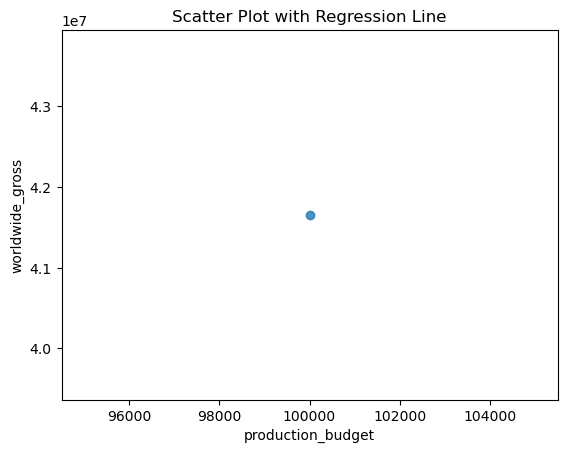

In [33]:
# Scatter plot with regression line
sns.regplot(x='production_budget', y='worldwide_gross', data=movie_df)
plt.title('Scatter Plot with Regression Line')
plt.show()

In [ ]:
# Create new variable to 
top_10_genres = []
for k in

In [ ]:
"Movie_Info[\"Primary_Genre\"] = Movie_Info[\"Genre\"].apply(lambda x: \"Horror\" if \"Horror\" in x else (\"Drama\" if \"Drama\" in x else (\"Animation\" if \"Animation\" in x else ( \"Sci-Fi\" if \"Sci-Fi\" in x else (\"Action\" if \"Action\" in x else (\"Comedy\" if \"Comedy\" in x else (\"Documentary\" if \"Documentary\" in x else (\"Fantasy\" if \"Fantasy\" in x else \"\"))))))))"

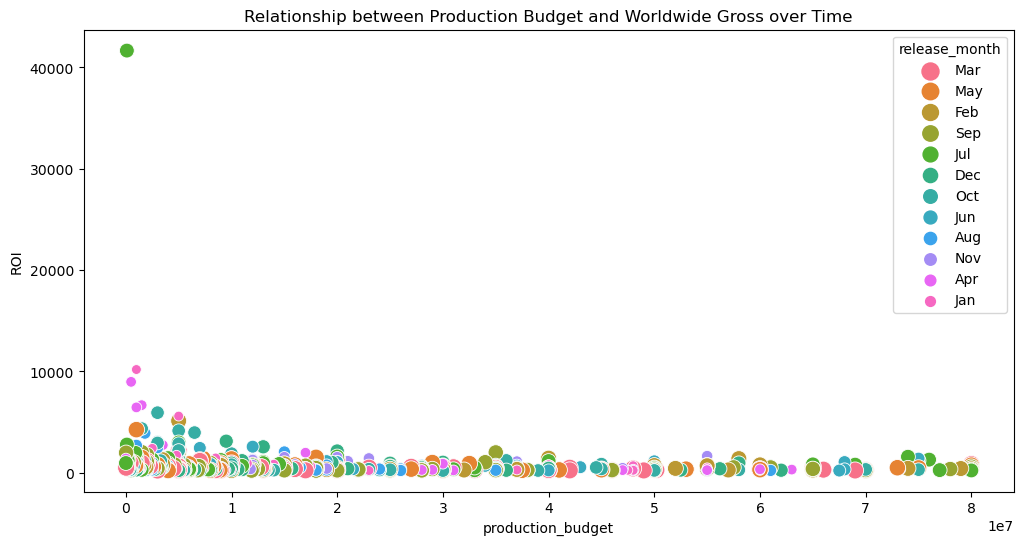

In [ ]:
plt.figure(figsize=(12,6))
sns.scatterplot(x='production_budget', y='ROI', hue='release_month', data=movie_df, size='release_month', sizes=(50, 150), legend="full")

plt.title('Relationship between Production Budget and Worldwide Gross over Time')
plt.show()

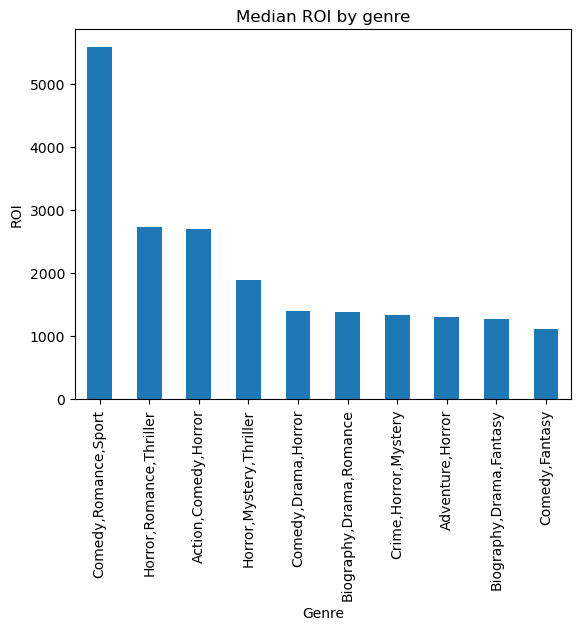

In [ ]:
#Bar chart for top 10 genres
top_10_genre = movie_df.groupby("genres")["ROI"].median().sort_values(ascending = False).head(10)
top_10_genre.plot(kind = "bar")
plt.xlabel("Genre")
plt.ylabel("ROI")
plt.title("Median ROI by genre")
plt.show()